# Selecting lags on a real world example using domain knowledge

In this notebook we shall show how we can use **domain knowledge** to decide which lags we could use for forecasting.

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The dataset was collected between January 2004 and March 2005.

It consists of hourly measurements of the different air pollutants: NO2, NOX, CO, C6H6, O3 and NMHC. The measurements are accompanied by local temperature and humidity values, also recorded hourly.

In the data collection experiments, scientists were testing new pollutant sensors. The values from the new sensors are stored in the variables called "_sensors". 

For comparison, data for the pollutants was also gathered from fixed stations that regularly measure the concentration of these gases. Those values are stored in the variables called "_true".

## Challenge

This dataset is particularly challenging because it does not have equidistant timestamps. The timestamps should be equidistant because the scientists aimed to have a pollutant record for each hour. But in practice, we have entire days of recordings missing, probably due to data collection failure.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Load data

In [2]:
filename = "../datasets/AirQualityUCI_ready.csv"
data = pd.read_csv(filename, parse_dates=["Date_Time"], index_col=["Date_Time"])

data.sort_index(inplace=True)
data.head()

CO_true  CO_sensor  NMHC_true  C6H6_true  NMHC_sensor  \
Date_Time                                                                    
2004-01-04 00:00:00      1.6     1143.0      106.0        6.3        825.0   
2004-01-04 01:00:00      1.2     1044.0      100.0        5.1        770.0   
2004-01-04 02:00:00      1.1     1034.0       71.0        4.1        716.0   
2004-01-04 03:00:00      0.9      956.0       72.0        4.0        713.0   
2004-01-04 04:00:00      0.7      909.0       44.0        2.4        615.0   

                     NOX_true  NOX_sensor  NO2_true  NO2_sensor  O3_sensor  \
Date_Time                                                                    
2004-01-04 00:00:00      96.0       986.0      86.0      1477.0      978.0   
2004-01-04 01:00:00      85.0      1031.0      70.0      1425.0      944.0   
2004-01-04 02:00:00      50.0      1085.0      55.0      1405.0      891.0   
2004-01-04 03:00:00    -200.0      1099.0    -200.0      1422.0      849.0   
2004-01-04 04:00:00      57.0      1237.0      49.0      1322.0      790.0   

                        T    RH      AH  
Date_Time                                
2004-01-04 00:00:00  12.0  61.6  0.8593  
2004-01-04 01:00:00  11.5  63.9  0.8652  
2004-01-04 02:00:00  10.7  67.2  0.8630  
2004-01-04 03:00:00   9.0  73.1  0.8394  
2004-01-04 04:00:00  10.2  66.6  0.8299

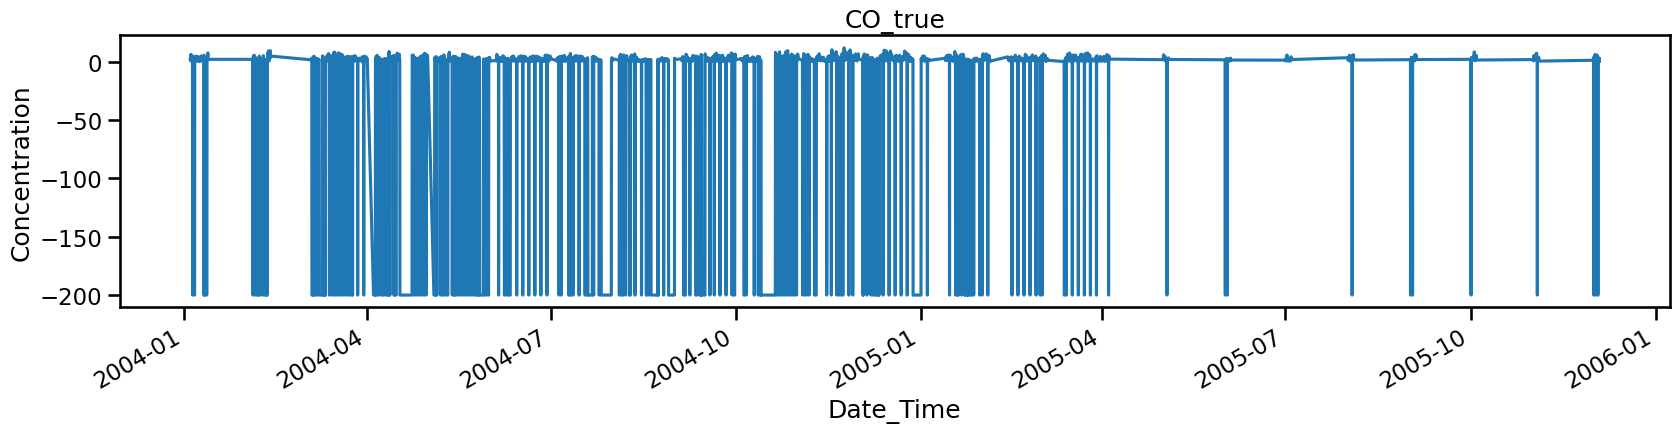

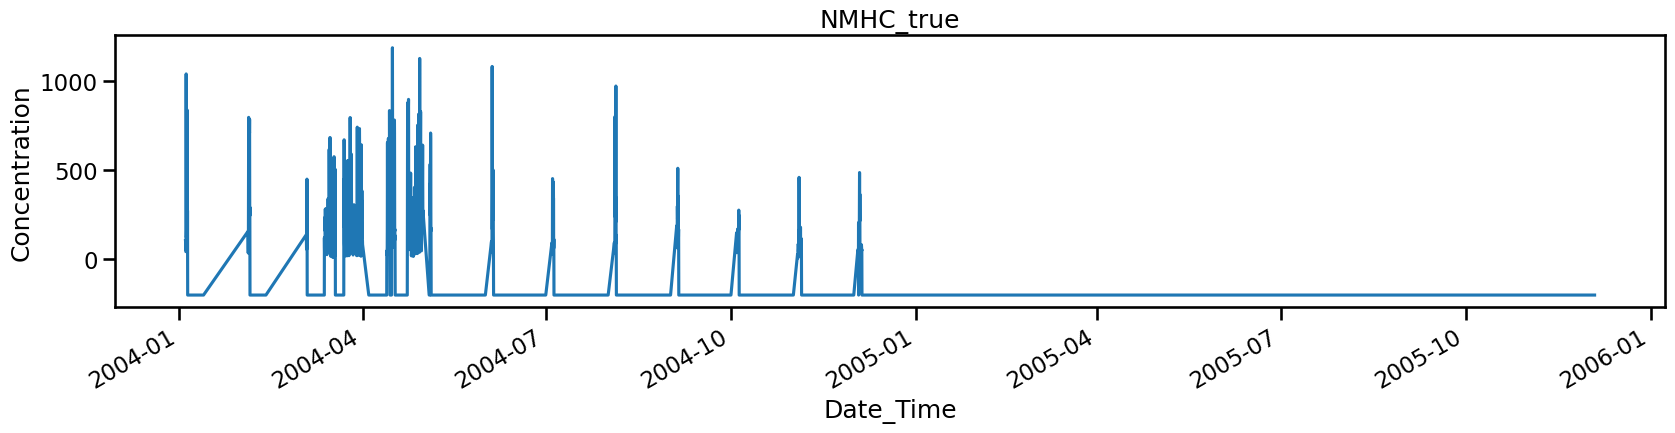

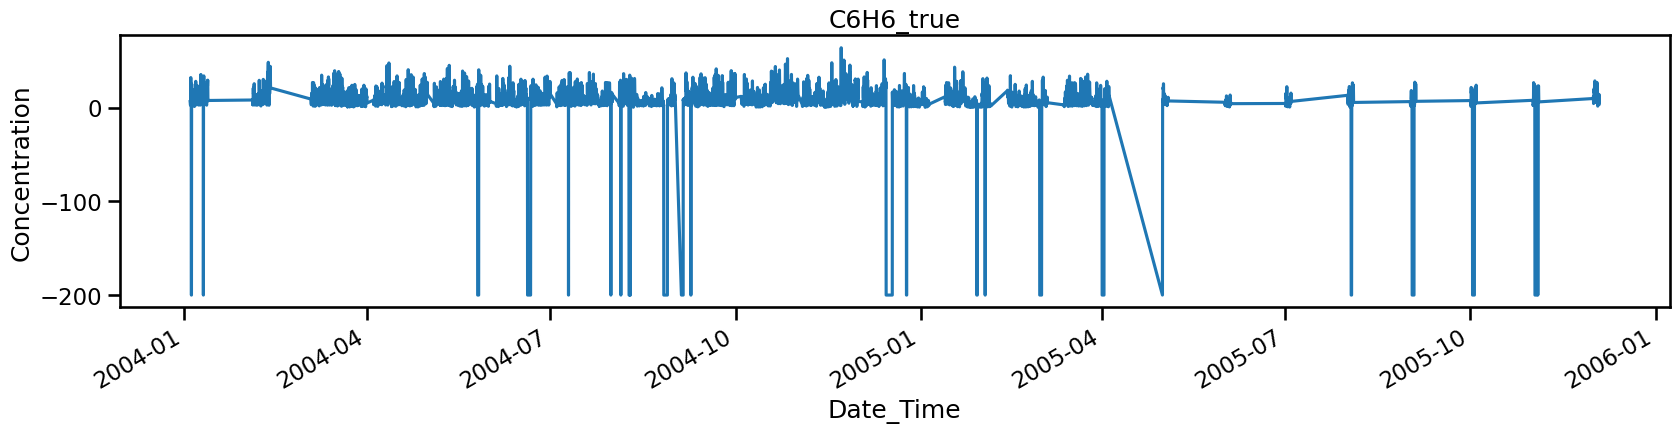

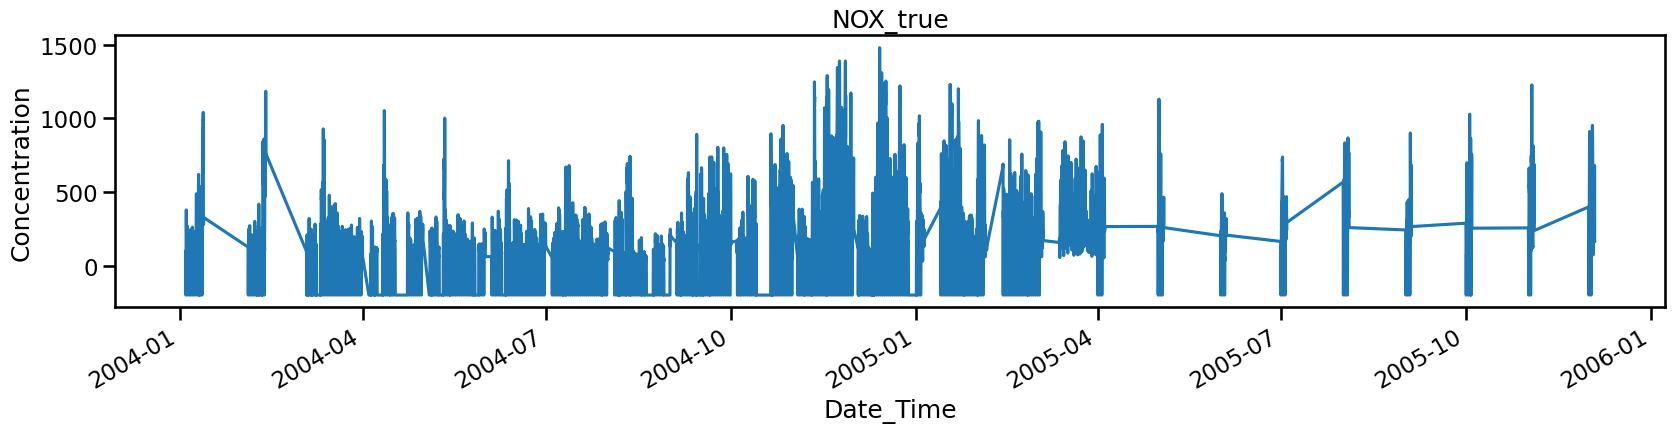

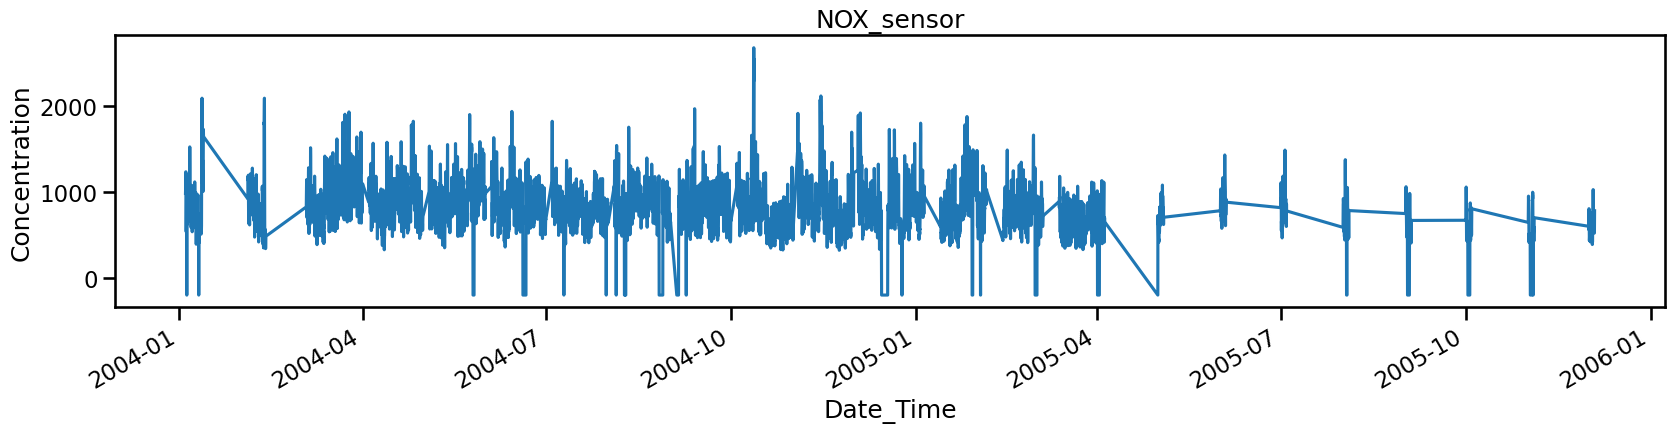

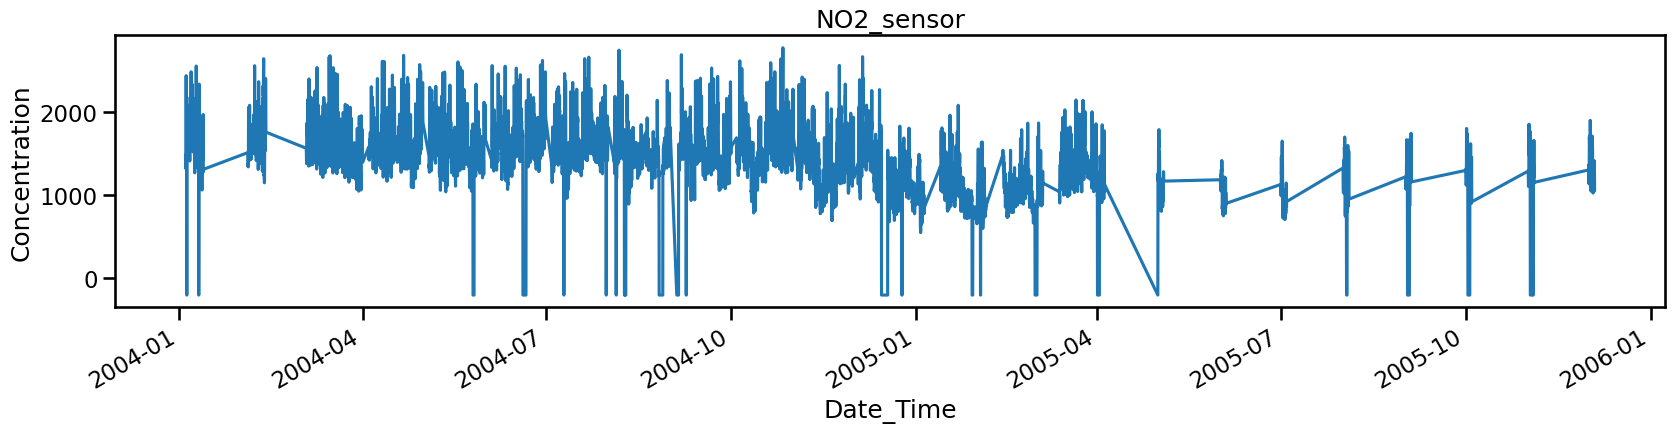

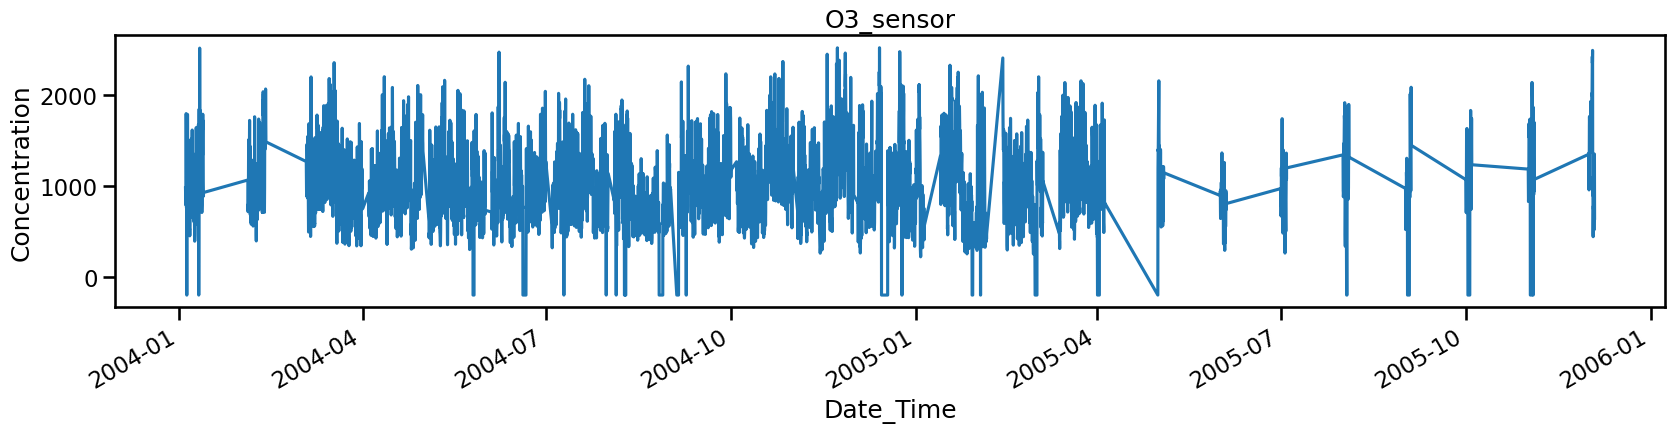

In [3]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

See the analysis in section 2 notebook 2. Due to data quality issues we will for this demo:

- reduce the data to the span between March 2004 and April 2005 (best quality).

- resample the time series to ensure that the time between each row is one hour.

- work only with the sensor values.

- remove negative values, that is, remove outliers.




In [4]:
# Reduce the time span.
data = data["2004-04-01":"2005-04-30"]

In [5]:
# Resample freq to be hourly. If there are gaps larger
# than one hour they will be representing as NaNs.
data = data.asfreq("1H")

In [6]:
data.columns

Index(['CO_true', 'CO_sensor', 'NMHC_true', 'C6H6_true', 'NMHC_sensor',
       'NOX_true', 'NOX_sensor', 'NO2_true', 'NO2_sensor', 'O3_sensor', 'T',
       'RH', 'AH'],
      dtype='object')

In [7]:
# Remove measurements from fixed stations.
# We'll only be using sensor data.
drop_vars = [var for var in data.columns if "_true" in var]

# Remove adjusted humidity.
drop_vars.append("AH")

# Remove variables.
data.drop(labels=drop_vars, axis=1, inplace=True)

In [8]:
data.columns

Index(['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor',
       'T', 'RH'],
      dtype='object')

In [9]:
# Impute negative values with NaNs
data[data < 0] = np.NaN

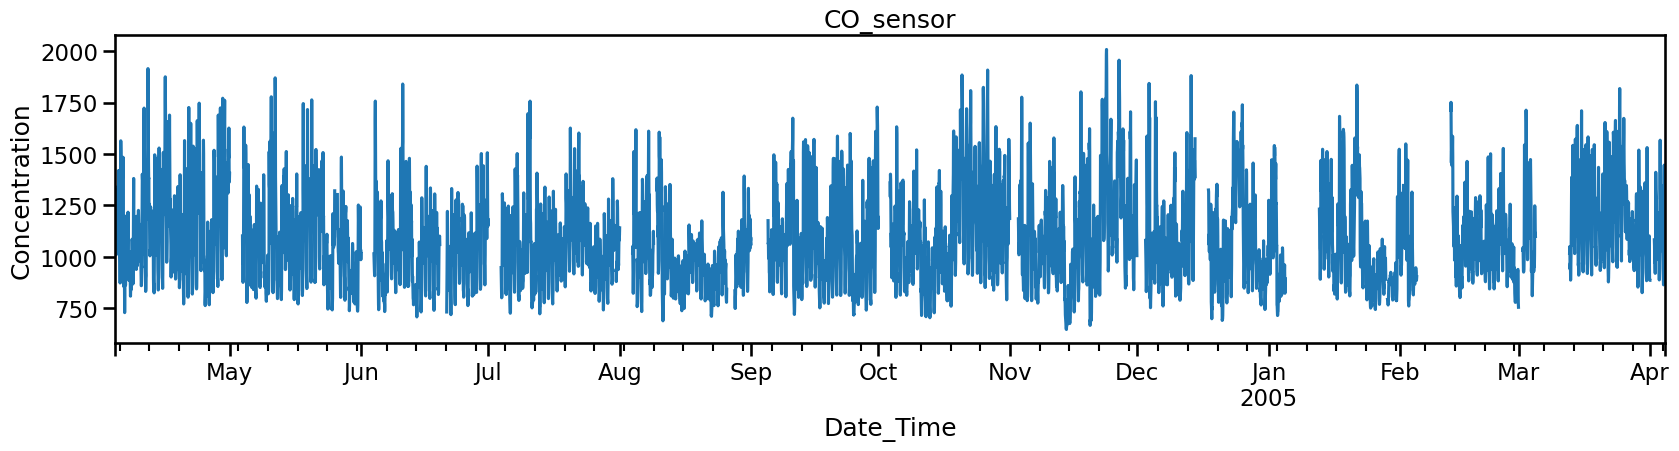

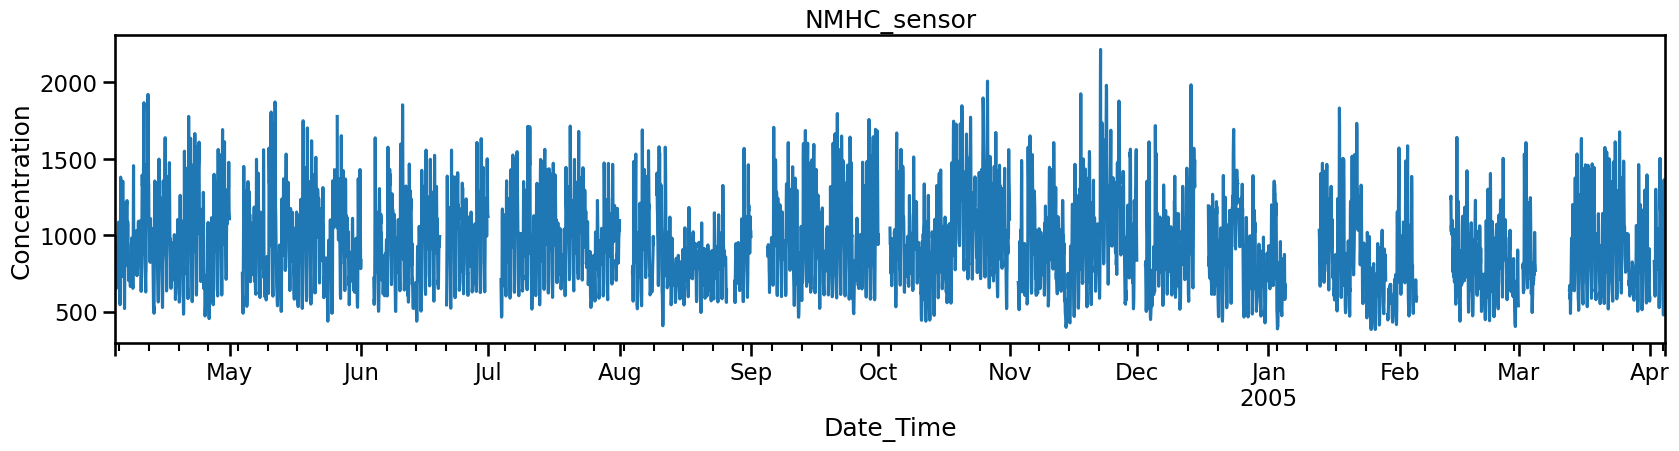

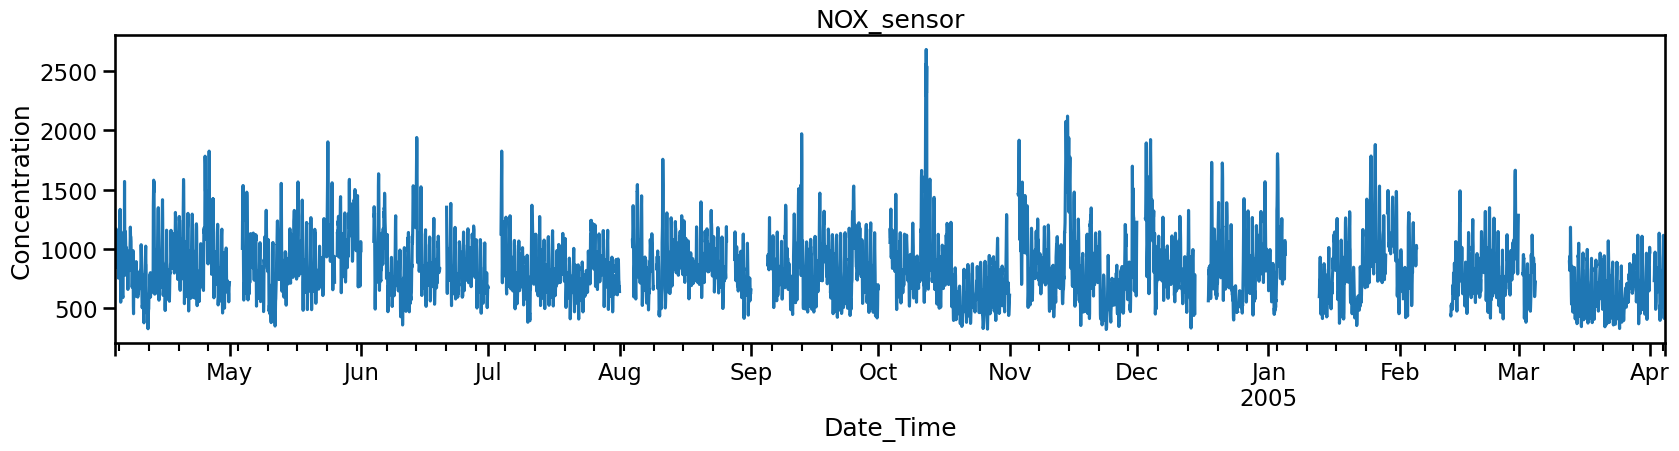

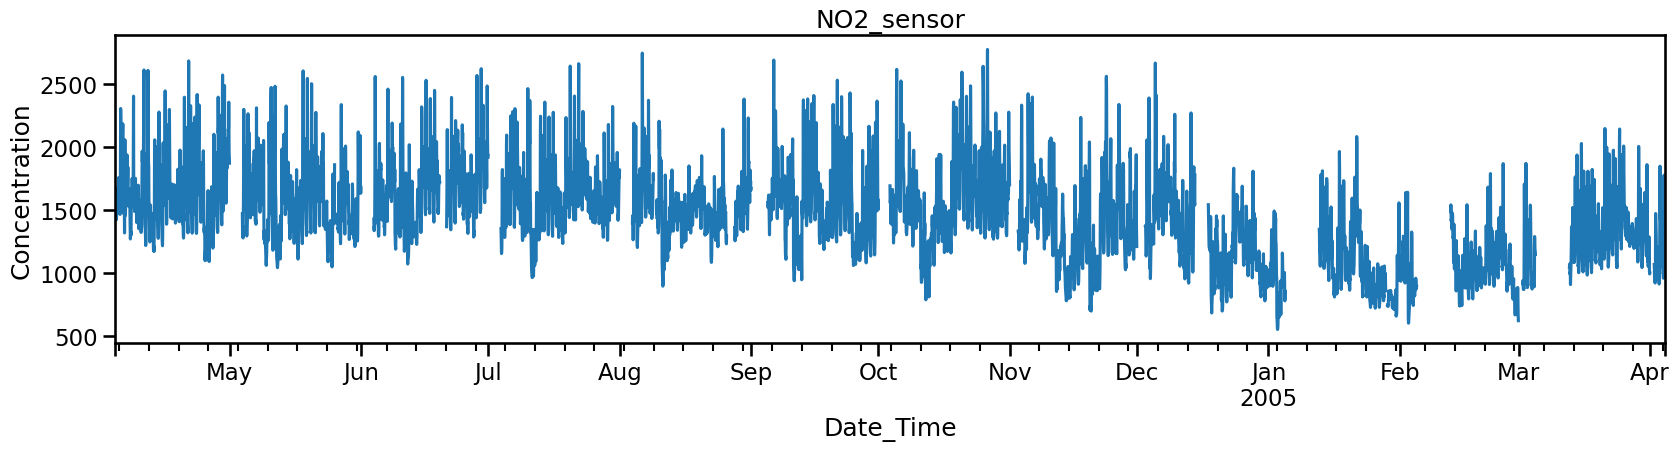

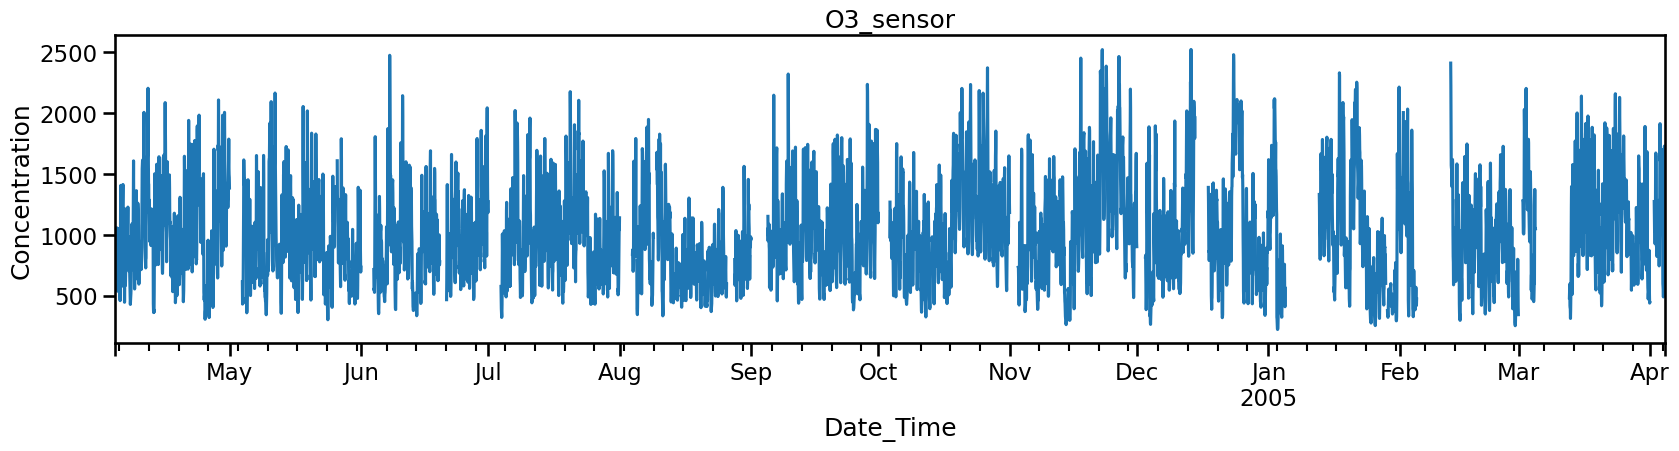

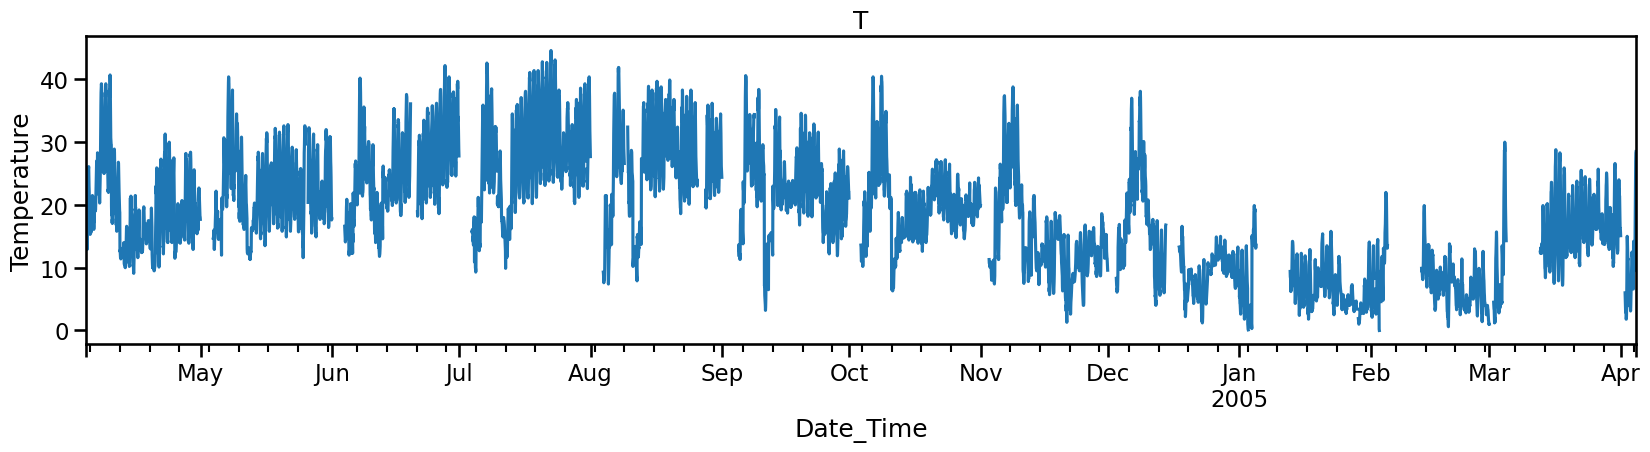

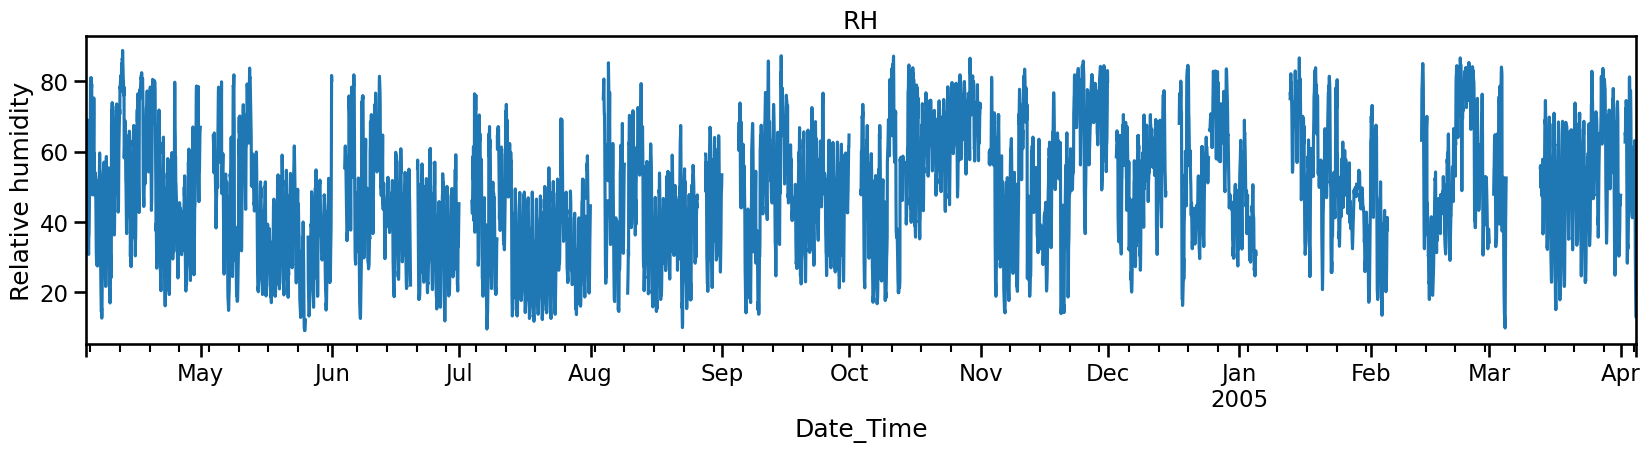

In [10]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

# Domain knowledge

- Intuitively the concentration of pollutants will be related to what it was in the short term past. The timescales here would be determined by the how much the pollutants are emitted and how long they take to diffuse into the environment. Therefore, a small number of recent lags would be reasonable (e.g., lag of 1 hour, 2 hour, 3 hour)

- We might expect a daily pattern to air pollution concentration due to traffic and commuting patterns (e.g., people going to work, transporting children to school, etc.). In addition to this you have the daily cycle for temperature and humidity which may affect pollution concentration. This would suggest a lag of 24 hours would be helpful (i.e., considering what happened this time yesterday)

- Likewise we might expect weekends to behave differently to weekdays. This suggests there might a weekly seasonality. Therefore, a lag of one week (7x24 hours) could be helpful.

- Different times of year have different temperatures and potentially changes in commuting patterns (e.g., more people may walk in the summer than winter). This could introduce a yearly seasonality and therefore a lag of 1 year (~ 365x24 hours) could be considered.

Let's validate some of these assumption using a variety of plots.

In [11]:
# Extract a bunch of date time features to use to check for
# seasonality
data["date"] = data.index.date
data["time_of_day"] = data.index.hour
data["month"] = data.index.month
data["day_of_week"] = data.index.dayofweek
data["week_of_year"] = data.index.isocalendar().week

In [12]:
# These variables will need different y labels for plotting
# compared to all the other columns
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

## Daily seasonality

Text(0, 0.5, 'Relative humidity')

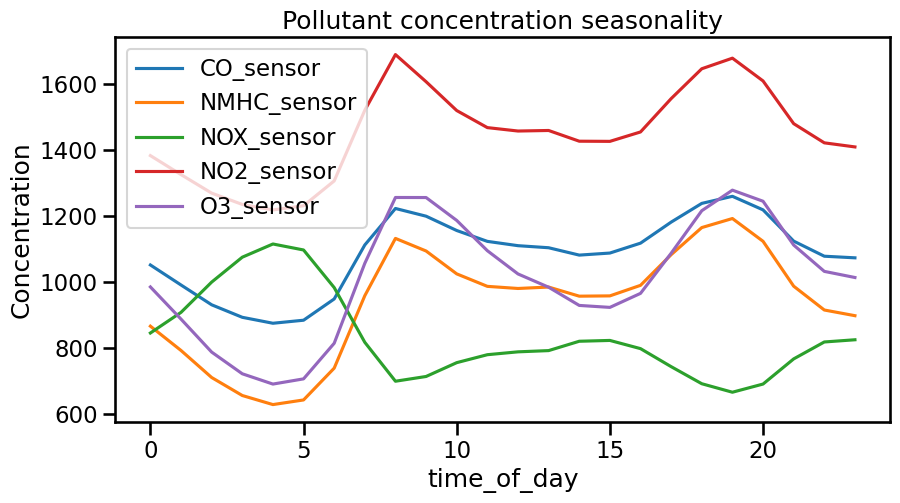

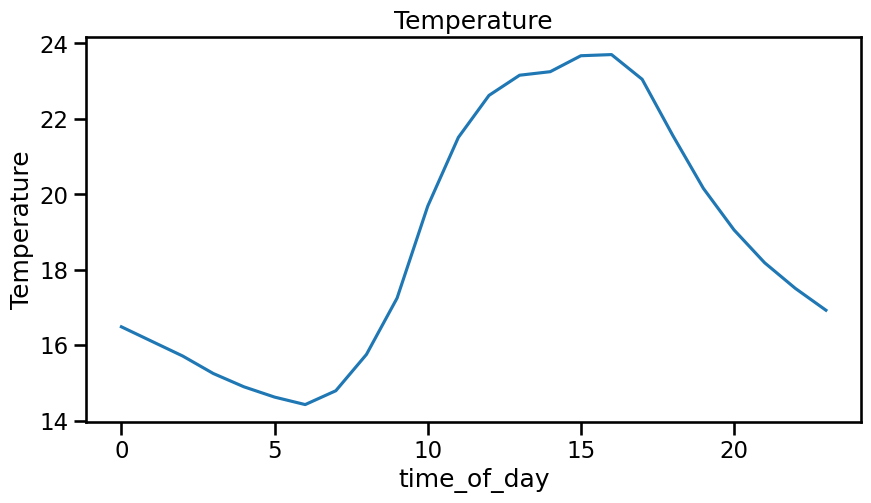

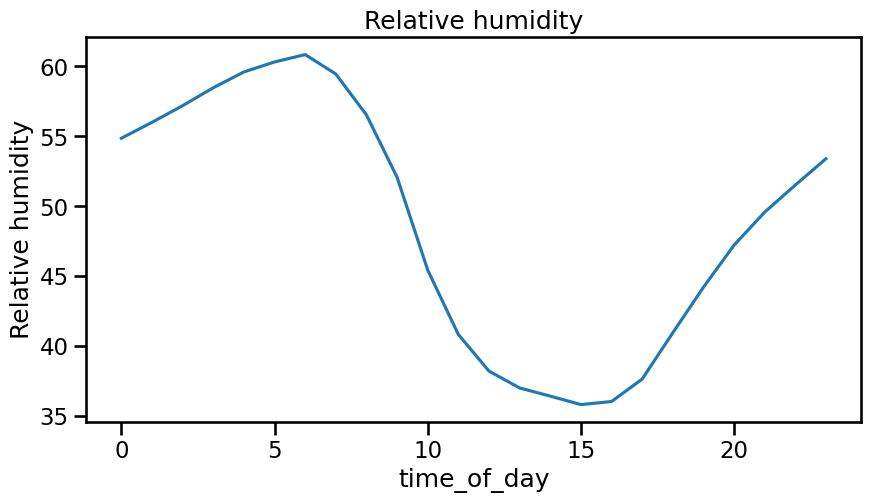

In [13]:
sensor_cols = [col for col in data.columns if "sensor" in col]
fig, ax = plt.subplots(figsize=(10, 5))
data.groupby("time_of_day")[sensor_cols].mean().plot(ax=ax)
plt.title("Pollutant concentration seasonality")
plt.ylabel("Concentration")

fig, ax = plt.subplots(figsize=(10, 5))
data.groupby("time_of_day")["T"].mean().plot(ax=ax)
plt.title("Temperature")
plt.ylabel("Temperature")

fig, ax = plt.subplots(figsize=(10, 5))
data.groupby("time_of_day")["RH"].mean().plot(ax=ax)
plt.title("Relative humidity")
plt.ylabel("Relative humidity")

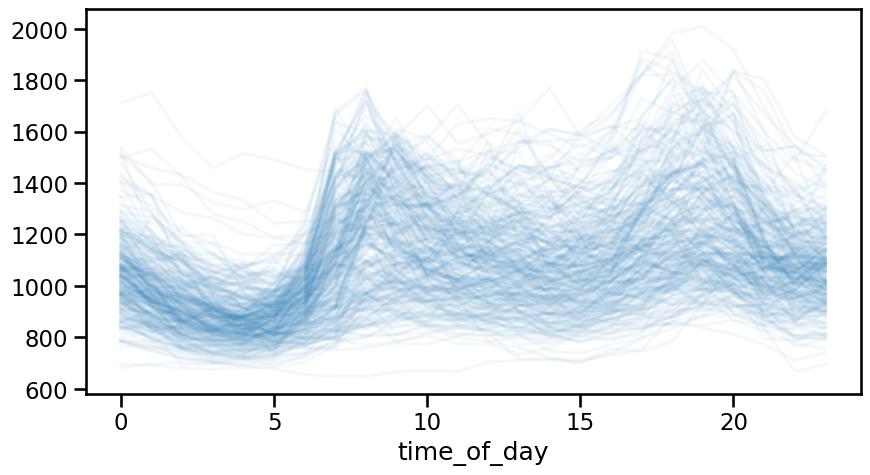

In [15]:
fig, ax = plt.subplots(figsize=[10, 5])
cmap = sns.color_palette("Blues", n_colors=5)
kek = (
    data.pivot(index=["time_of_day"], columns=["date"])["CO_sensor"].plot(
        legend=False, alpha=0.05, color=cmap[3], ax=ax
    )
)

In [18]:
data.pivot(index=["time_of_day"], columns=["date"])["CO_sensor"]

date         2004-04-04  2004-04-05  2004-04-06  2004-04-07  2004-04-08  \
time_of_day                                                               
0                1224.0      1065.0       974.0      1217.0      1074.0   
1                1215.0       999.0       880.0       983.0      1039.0   
2                1115.0       911.0       853.0      1007.0       963.0   
3                1124.0       873.0       912.0       957.0       889.0   
4                1028.0       881.0       863.0       914.0       868.0   
5                1010.0       967.0       729.0       886.0       877.0   
6                1074.0      1280.0       830.0       899.0      1056.0   
7                1034.0      1564.0      1198.0       942.0      1288.0   
8                1130.0      1505.0       971.0      1022.0      1381.0   
9                1275.0      1309.0       885.0      1009.0      1113.0   
10               1324.0      1035.0       862.0      1025.0      1062.0   
11               1268.0      1148.0       892.0       977.0      1094.0   
12               1272.0      1152.0       933.0       936.0      1050.0   
13               1160.0      1131.0       975.0       884.0      1056.0   
14               1136.0      1142.0       927.0       809.0       944.0   
15               1296.0      1197.0       993.0       852.0      1003.0   
16               1345.0       960.0      1053.0       872.0      1018.0   
17               1296.0      1077.0      1116.0       839.0      1108.0   
18               1258.0      1377.0      1097.0       854.0      1049.0   
19               1420.0      1405.0      1116.0       971.0      1078.0   
20               1366.0      1484.0      1057.0       985.0       999.0   
21               1113.0      1187.0       973.0      1027.0       943.0   
22               1196.0       870.0      1016.0      1012.0       987.0   
23               1188.0       932.0      1120.0      1086.0       939.0   

date         2004-04-09  2004-04-10  2004-04-11  2004-04-12  2004-04-13  ...  \
time_of_day                                                              ...   
0                1197.0       995.0      1043.0      1257.0       893.0  ...   
1                1006.0       960.0       948.0      1246.0       844.0  ...   
2                 987.0       890.0       955.0      1166.0       837.0  ...   
3                 958.0       860.0       915.0      1062.0       868.0  ...   
4                 962.0       860.0       832.0      1005.0       825.0  ...   
5                 958.0       883.0       846.0      1032.0       956.0  ...   
6                 976.0       929.0       897.0      1034.0      1124.0  ...   
7                1088.0      1100.0       908.0      1024.0      1496.0  ...   
8                1159.0      1257.0      1348.0      1243.0      1452.0  ...   
9                1156.0      1402.0      1384.0      1148.0      1172.0  ...   
10               1202.0      1376.0      1473.0      1182.0      1020.0  ...   
11               1226.0      1374.0      1360.0      1015.0      1044.0  ...   
12               1181.0      1381.0      1305.0      1175.0      1020.0  ...   
13               1062.0      1282.0      1337.0      1224.0      1009.0  ...   
14               1013.0      1188.0      1414.0      1123.0      1073.0  ...   
15               1029.0      1227.0      1463.0      1187.0      1098.0  ...   
16               1144.0      1364.0      1530.0      1116.0      1061.0  ...   
17               1159.0      1531.0      1915.0      1131.0      1289.0  ...   
18               1113.0      1694.0      1882.0      1215.0      1442.0  ...   
19               1100.0      1723.0      1589.0      1077.0      1479.0  ...   
20               1037.0      1356.0      1463.0      1210.0      1266.0  ...   
21               1055.0      1084.0      1380.0      1181.0      1149.0  ...   
22                980.0      1039.0      1383.0      1088.0      1168.0  ...   
23               1083.0      1011.0      1181.0  

In [16]:
kek

<Axes: xlabel='time_of_day'>

We know that the daily pattern might shift at different times of the year. Let's plot the full dataset in addition to the averages.

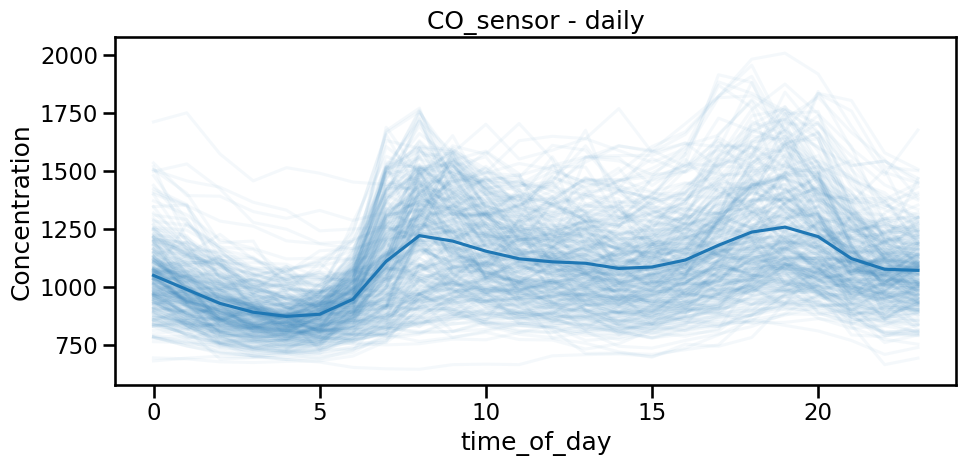

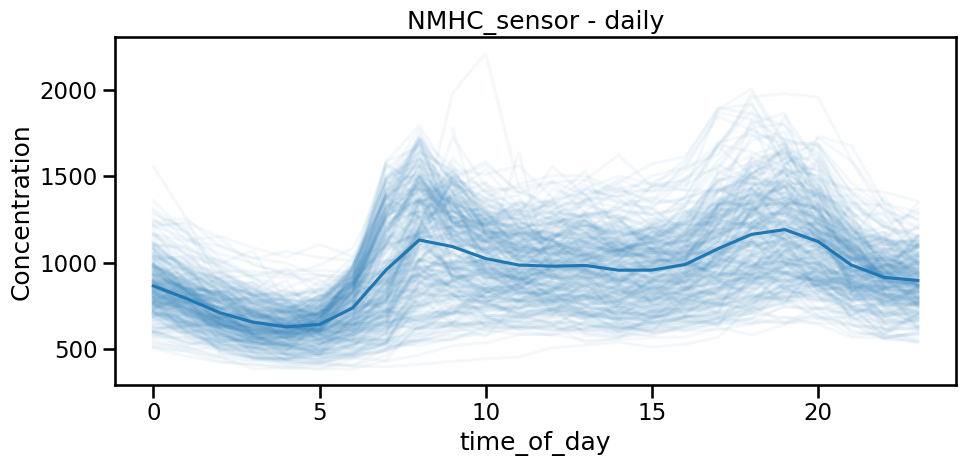

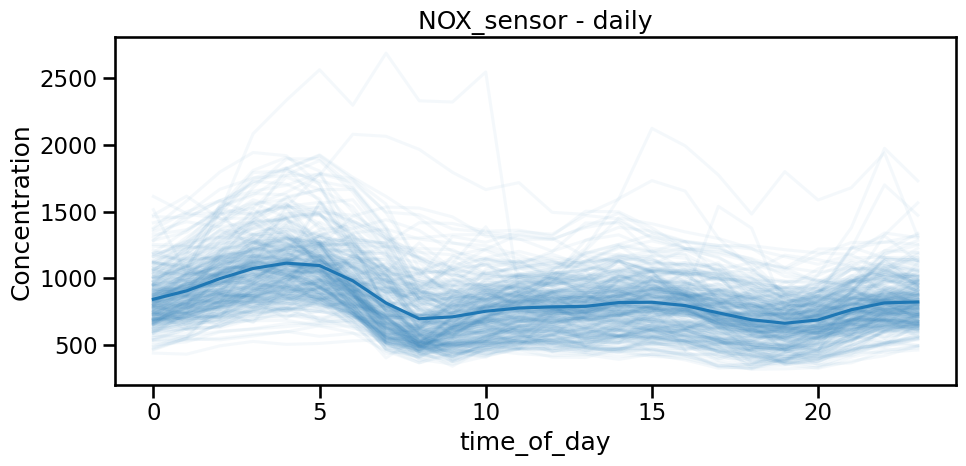

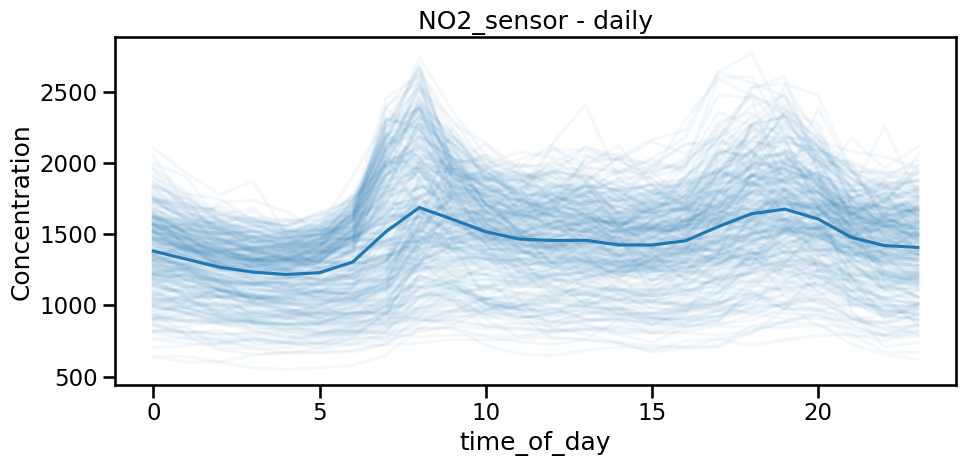

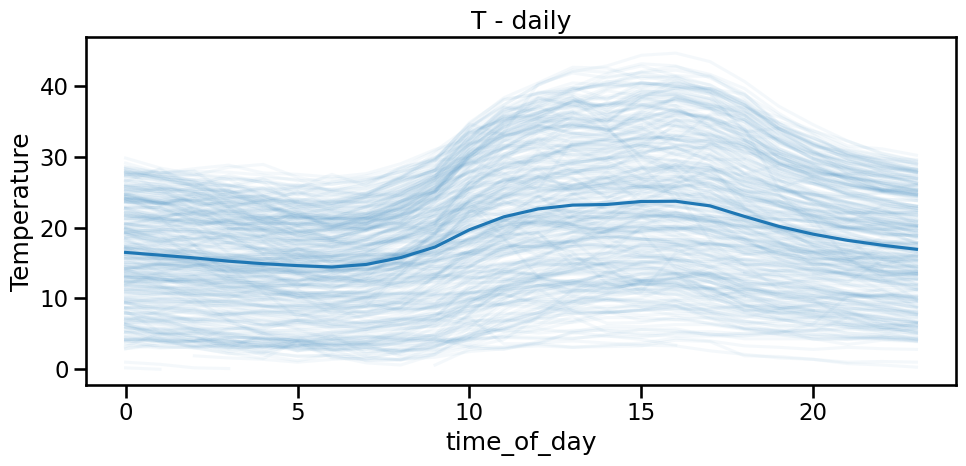

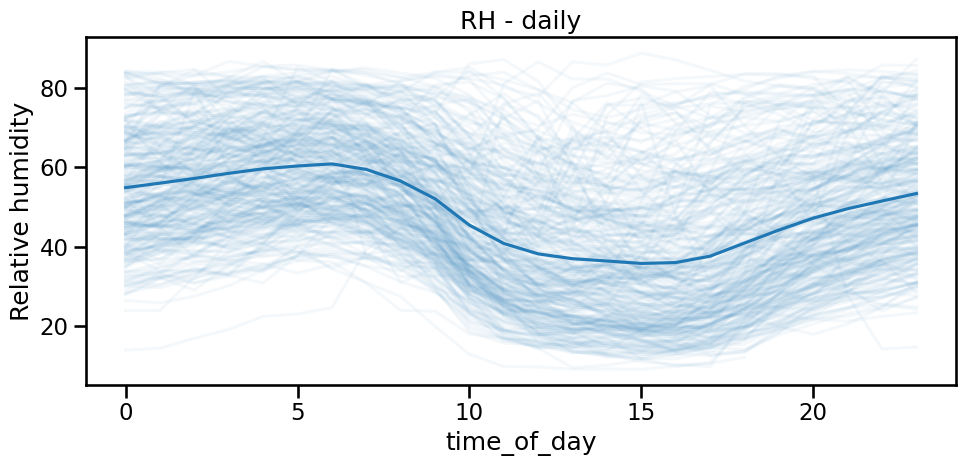

In [15]:
cmap = sns.color_palette("Blues", n_colors=5)
variables = [
    "CO_sensor",
    "NMHC_sensor",
    "NOX_sensor",
    "NO2_sensor",
    "O3_sensor",
    "T",
    "RH",
]

for var in variables:
    fig, ax = plt.subplots(figsize=[10, 5])

    (
        data.pivot(index=["time_of_day"], columns=["date"])[var].plot(
            legend=False, alpha=0.05, color=cmap[3], ax=ax
        )
    )

    (data.groupby("time_of_day").mean(numeric_only=True)[var].plot(ax=ax))

    ax.set_title(f"{var} - daily")

    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")

    plt.tight_layout()

We observe a clear daily pattern amongst all the concentrations, the temperature, and the relative humidity. This is enough to suggest a lag of 24 hours.

## Weekly seasonality

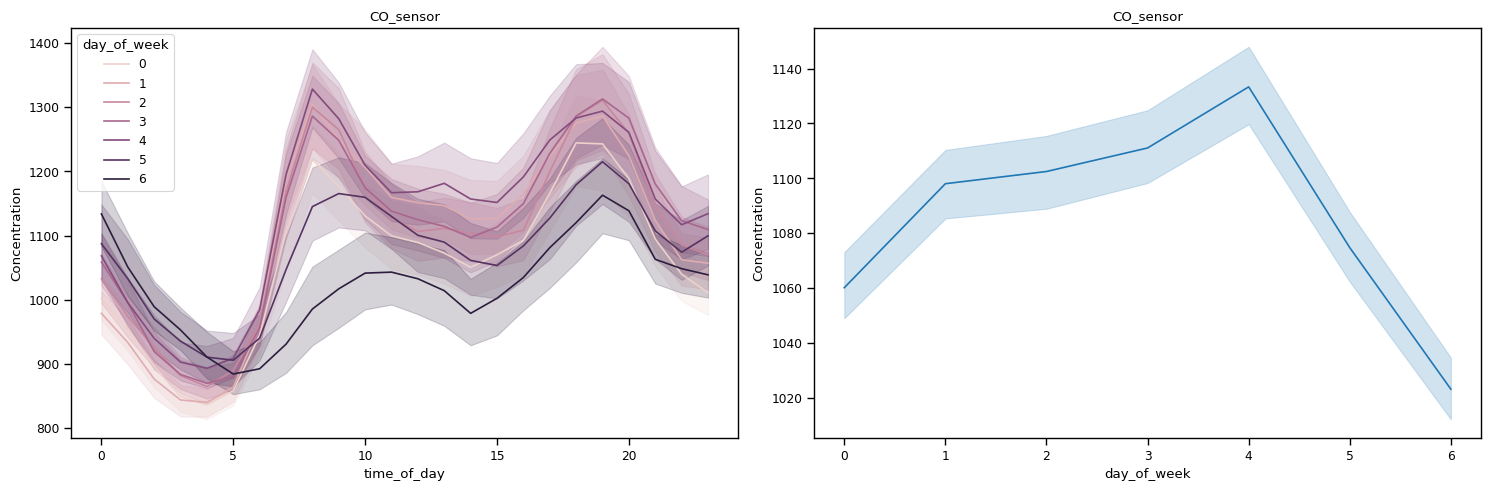

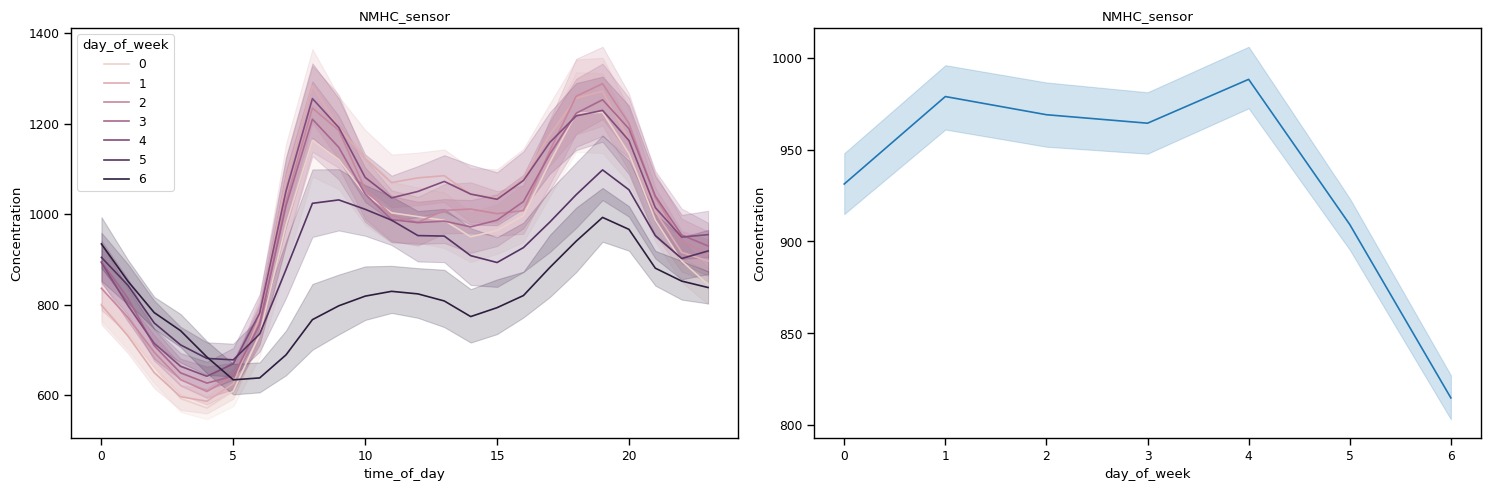

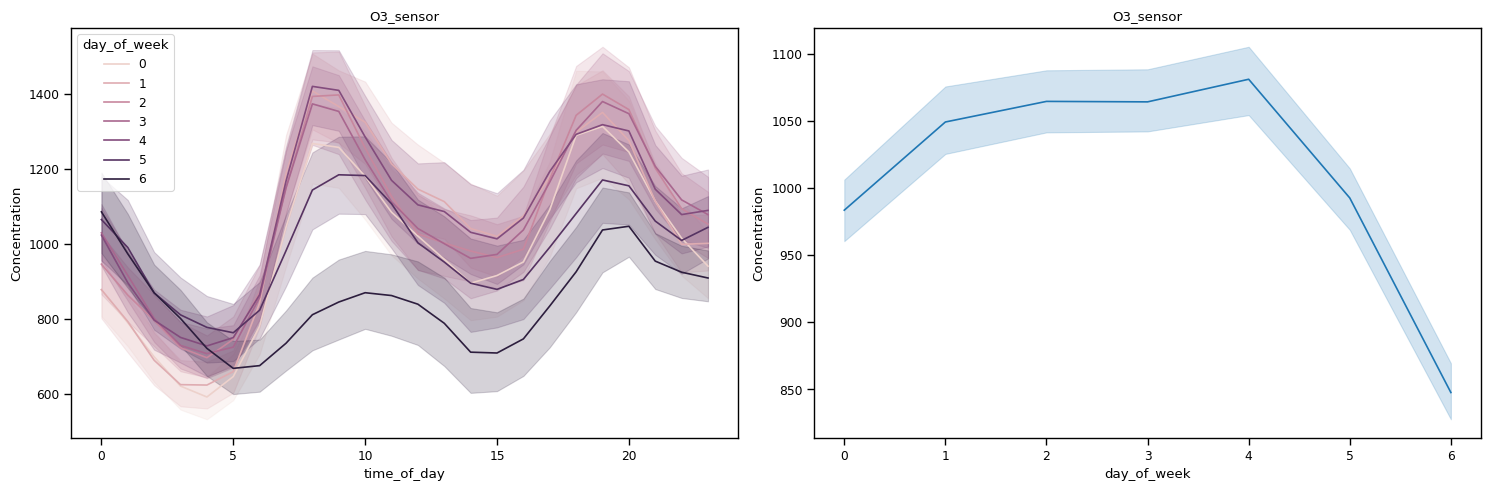

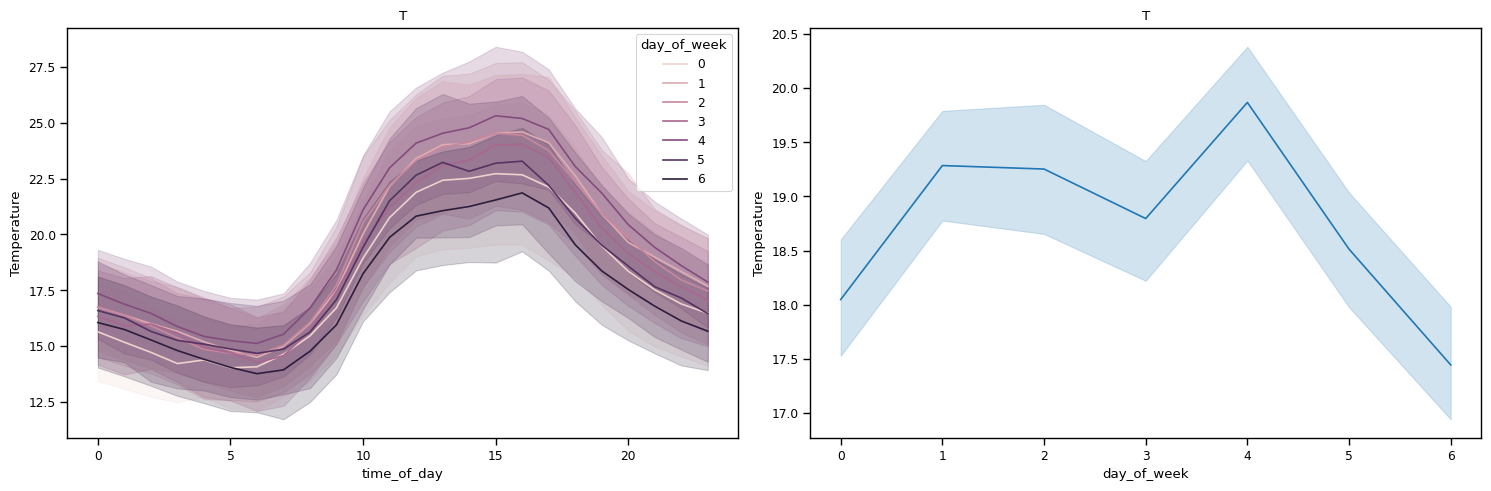

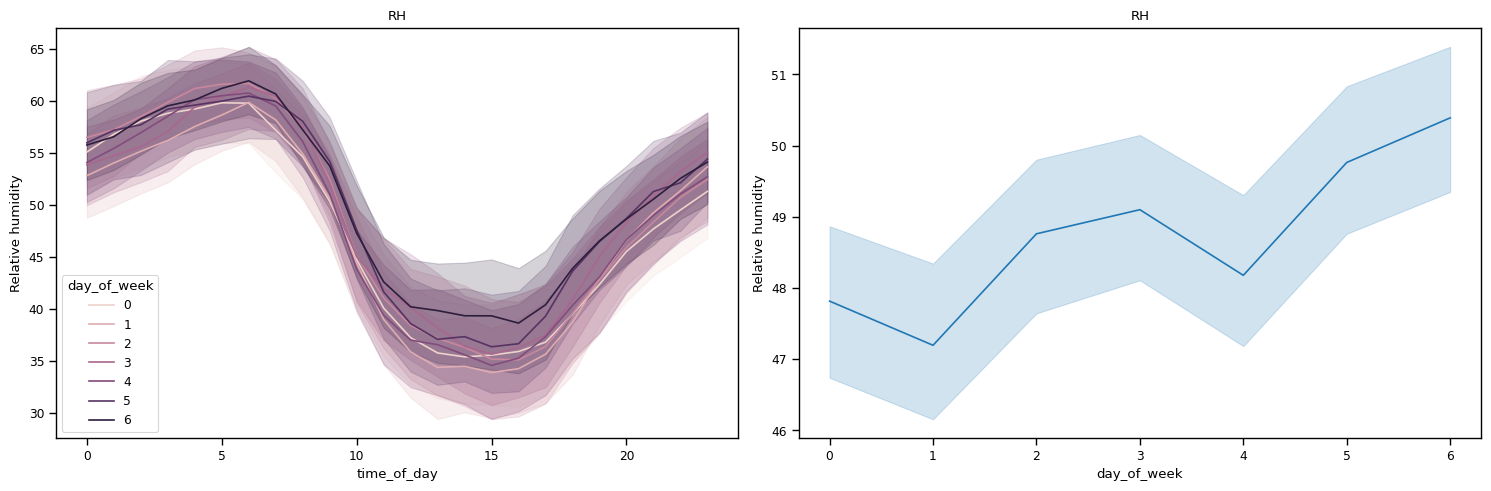

In [17]:
pd.plotting.register_matplotlib_converters()
with sns.plotting_context("paper"):
    for var in variables:
        fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
        ylabel = col_by_ylabel.get(var)

        sns.lineplot(data=data, y=var, x="time_of_day", hue="day_of_week", ax=ax[0])

        if ylabel:
            ax[0].set_ylabel(ylabel)
        else:
            ax[0].set_ylabel("Concentration")
        ax[0].set_title(var)

        sns.lineplot(x="day_of_week", y=var, data=data, ax=ax[1])

        if ylabel:
            ax[1].set_ylabel(ylabel)
        else:
            ax[1].set_ylabel("Concentration")
        ax[1].set_title(var)

        plt.tight_layout()

# Yearly seasonality

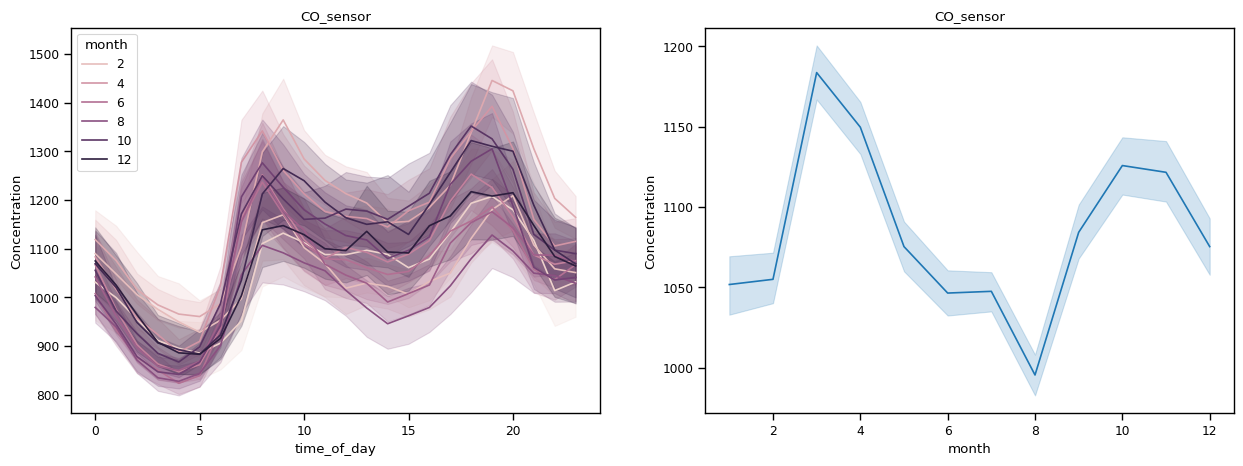

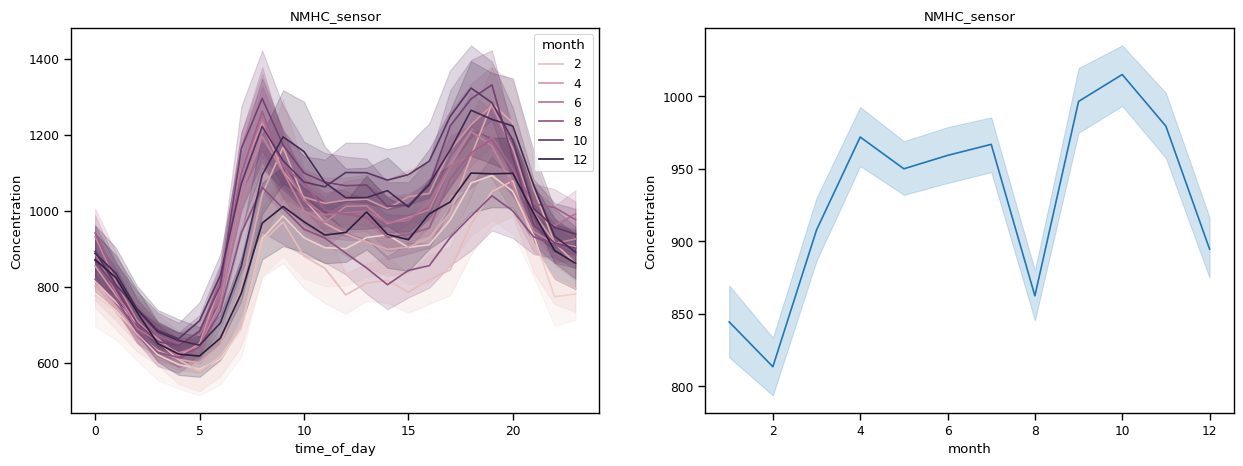

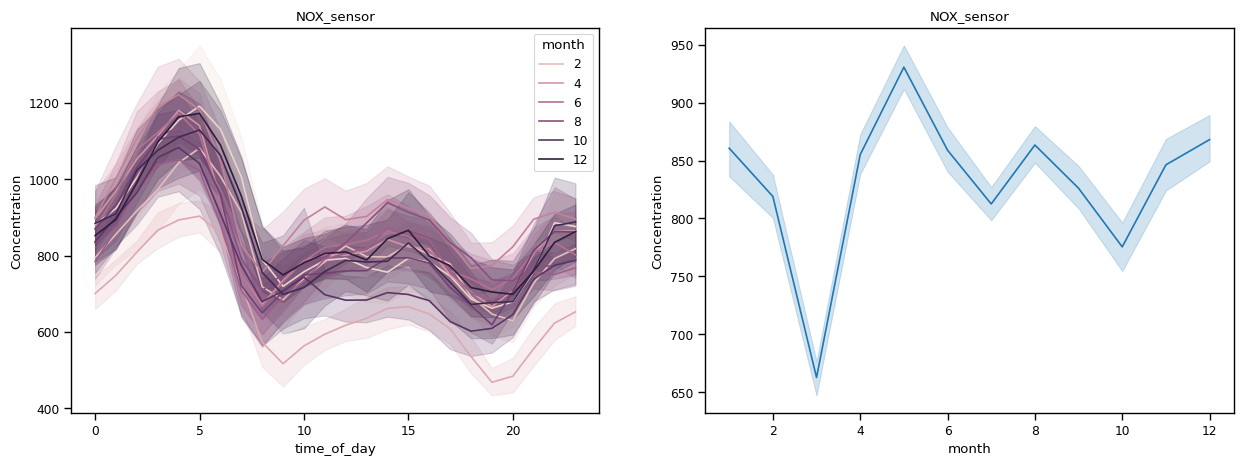

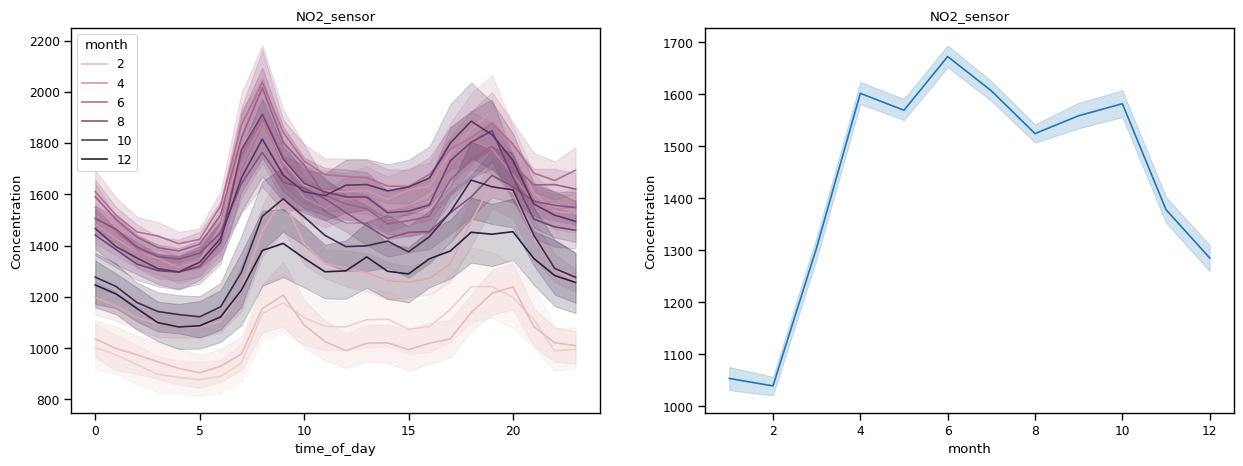

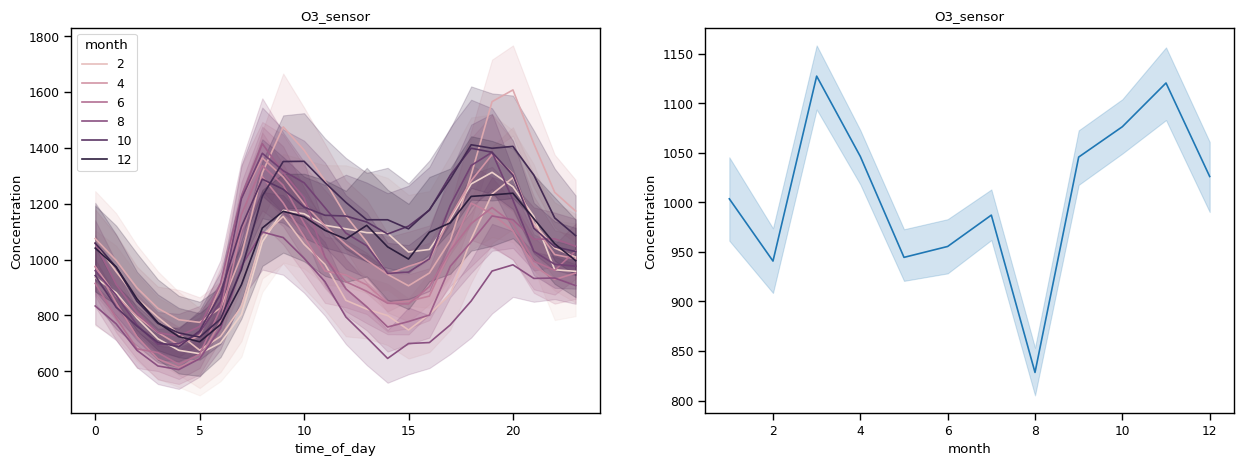

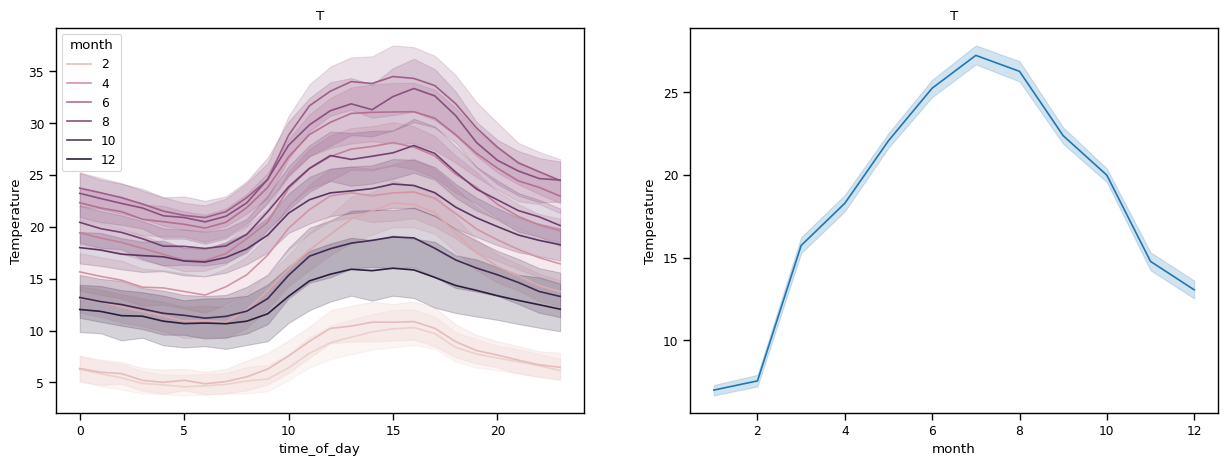

In [18]:
with sns.plotting_context("paper"):
    for var in variables:
        fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
        ylabel = col_by_ylabel.get(var)

        sns.lineplot(data=data, y=var, x="time_of_day", hue="month", ax=ax[0])

        if ylabel:
            ax[0].set_ylabel(ylabel)
        else:
            ax[0].set_ylabel("Concentration")
        ax[0].set_title(var)

        sns.lineplot(x="month", y=var, data=data, ax=ax[1])

        if ylabel:
            ax[1].set_ylabel(ylabel)
        else:
            ax[1].set_ylabel("Concentration")
        ax[1].set_title(var)

We can see that there are patterns which repeat daily, weekly, and yearly. Therefore, seasonal lags could be helpful. In addition to that we know that the physical process itself means that recent lags will be relevant. So on the basis of all of this it would be reasonable to try the following lags to begin with: 24 hours, 7x24 hours, 24x365 hours, 1 hour, 2 hours, 3 hours. 

It is worth noting that there are other ways of encoding the various seasonal components as features which we discuss later in the course.